In [1]:
import os
from torchvision import datasets
import torchvision.transforms as T
from imgaug import augmenters as iaa
import numpy as np

root = os.path.join(os.getenv('TORCH_HOME'), 'cifar100')

train_transformations = T.Compose([
    np.asarray,
    iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.CropAndPad(px=(-4, 4), pad_mode="reflect"),
    ]).augment_image,
    np.copy,
    T.ToTensor(),
    T.Normalize(
        mean=(0.5074, 0.4867, 0.4411),
        std=(0.2011, 0.1987, 0.2025)
    )
])

training_dataset = datasets.CIFAR100(
    root=root,
    train=True,
    download=True,
    transform=train_transformations,
)

test_transformations = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=(0.5074, 0.4867, 0.4411),
        std=(0.2011, 0.1987, 0.2025)
    )
])

test_dataset = datasets.CIFAR100(
    root=root,
    train=False,
    download=True,
    transform=test_transformations
)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
from torch.utils.data import DataLoader

batch_size = 128
num_workers = 8

train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [3]:
device = 'cuda'

for batch in train_dataloader:
    break

example_images, example_labels = batch

example_images = example_images.to(device)
example_labels = example_labels.to(device)
example_images.shape

torch.Size([128, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


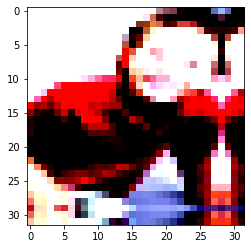

In [4]:
import matplotlib.pyplot as plt
import torch

example_img = torch.permute(example_images[0].cpu(), (1, 2, 0))
# img = images[0]
plt.imshow(example_img)
plt.show()

In [5]:
import torch.nn as nn
from torchvision.models.resnet import resnet18, resnet50

teacher_model = resnet50()
student_model = resnet18()

In [6]:
from torchinfo import summary

print(summary(teacher_model, input_size=(1, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─ReLU: 1-3                              [1, 64, 16, 16]           --
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Sequential: 1-5                        [1, 256, 8, 8]            --
│    └─Bottleneck: 2-1                   [1, 256, 8, 8]            --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-6                    [1, 64, 8, 8]             --
│ 

In [7]:
print(summary(student_model, input_size=(1, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─ReLU: 1-3                              [1, 64, 16, 16]           --
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Sequential: 1-5                        [1, 64, 8, 8]             --
│    └─BasicBlock: 2-1                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-6                    [1, 64, 8, 8]             --
│

In [8]:
teacher_model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [9]:
student_model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [10]:
teacher_model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Linear(512, 100),
)

student_model.fc = nn.Sequential(
    nn.Linear(512, 100),
)

In [11]:
teacher_model.to(device)
student_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
teacher_model(example_images).shape

torch.Size([128, 100])

In [13]:
student_model(example_images).shape

torch.Size([128, 100])

In [14]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW

teacher_loss_function = nn.CrossEntropyLoss()
student_loss_function = nn.KLDivLoss(reduction="batchmean")

def train_step(teacher, student, teacher_optimizer, student_optimizer, batch) -> dict:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    
    t = teacher(images)
    teacher_loss = teacher_loss_function(t, labels)
    s = student(images)
    student_ce_loss = teacher_loss_function(s, labels)
    student_kd_loss = student_loss_function(F.log_softmax(s, dim=1), F.softmax(t.detach(), dim=1))
    student_loss = student_kd_loss + student_ce_loss
    
    teacher_optimizer.zero_grad()
    teacher_loss.backward()
    teacher_optimizer.step()
    
    student_optimizer.zero_grad()
    student_loss.backward()
    student_optimizer.step()
    
    return {
        "teacher_loss": float(teacher_loss.item()),
        "student_loss": float(student_loss.item()),
    }


learning_rate = 1e-2
teacher_optimizer = AdamW(teacher_model.parameters(), lr=learning_rate)
student_optimizer = AdamW(student_model.parameters(), lr=learning_rate)

train_step(teacher_model, student_model, teacher_optimizer, student_optimizer, batch)

{'teacher_loss': 4.618436336517334, 'student_loss': 5.239637851715088}

In [15]:
torch.hub.list('pytorch/vision:v0.14.0')

Using cache found in /home/kiddos/pytorch/hub/pytorch_vision_v0.14.0


['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fcn_resnet101',
 'fcn_resnet50',
 'get_model_weights',
 'get_weight',
 'googlenet',
 'inception_v3',
 'lraspp_mobilenet_v3_large',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'raft_large',
 'raft_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf

In [16]:
def accuracy(predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    predicted_classes = torch.argmax(F.softmax(predictions, dim=1), dim=1)
    correct_predictions = torch.sum(predicted_classes == labels)
    return correct_predictions / len(labels)


def run_evaluation(teacher, student, dataloader) -> dict:
    ts = []
    ss = []
    for batch in dataloader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        t = teacher(images)
        s = student(images)
        ts.append(accuracy(t, labels))
        ss.append(accuracy(s, labels))
    ts = torch.mean(torch.stack(ts))
    ss = torch.mean(torch.stack(ss))
    return {
        'teacher_accuracy': ts,
        'student_accuracy': ss,
    }

run_evaluation(teacher_model, student_model, test_dataloader)

{'teacher_accuracy': tensor(0.0099, device='cuda:0'),
 'student_accuracy': tensor(0.0154, device='cuda:0')}

In [17]:
from tqdm.auto import tqdm

num_epochs = 50

def train():
    for epoch in range(num_epochs):
        with tqdm(total=len(train_dataloader), desc="Iteration: ") as progress_bar:
            for batch in train_dataloader:
                result = train_step(teacher_model, student_model, teacher_optimizer, student_optimizer, batch)
                progress_bar.update()

            eval_result = run_evaluation(teacher_model, student_model, test_dataloader)
            print(f"teacher accuracy: {eval_result['teacher_accuracy']}")
            print(f"student accuracy: {eval_result['student_accuracy']}")


train()

Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.040348101407289505
student accuracy: 0.0859375


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.07436709105968475
student accuracy: 0.1386471539735794


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.09206882864236832
student accuracy: 0.1819620281457901


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.10947389155626297
student accuracy: 0.21054193377494812


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.07466376572847366
student accuracy: 0.2366495281457901


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.15733781456947327
student accuracy: 0.2624604403972626


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.17207278311252594
student accuracy: 0.2841178774833679


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.18117089569568634
student accuracy: 0.3045886158943176


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.15714003145694733
student accuracy: 0.3284216821193695


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.1376582384109497
student accuracy: 0.32703718543052673


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.18018196523189545
student accuracy: 0.349683552980423


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.1943235844373703
student accuracy: 0.3570016026496887


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.1701938360929489
student accuracy: 0.35719937086105347


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.19214795529842377
student accuracy: 0.3674841821193695


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2129153460264206
student accuracy: 0.375593364238739


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.20787183940410614
student accuracy: 0.39734968543052673


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2386273741722107
student accuracy: 0.4048655033111572


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.23833070695400238
student accuracy: 0.3987341821193695


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.18433544039726257
student accuracy: 0.42464399337768555


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2056962102651596
student accuracy: 0.41416141390800476


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.24198971688747406
student accuracy: 0.435621052980423


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2434731125831604
student accuracy: 0.4351266026496887


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.26443830132484436
student accuracy: 0.4446202516555786


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2542523741722107
student accuracy: 0.43967562913894653


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2649327516555786
student accuracy: 0.4390822947025299


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.26967960596084595
student accuracy: 0.4457080662250519


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.26710838079452515
student accuracy: 0.4534216821193695


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2497033327817917
student accuracy: 0.45421281456947327


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.18660996854305267
student accuracy: 0.43275317549705505


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2606803774833679
student accuracy: 0.46884891390800476


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2542523741722107
student accuracy: 0.46766218543052673


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2763053774833679
student accuracy: 0.45747628808021545


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2444620281457901
student accuracy: 0.4738924205303192


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2848101258277893
student accuracy: 0.4650909900665283


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2714596688747406
student accuracy: 0.47053006291389465


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2640427350997925
student accuracy: 0.4764636158943176


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.29183149337768555
student accuracy: 0.4733979403972626


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2783821225166321
student accuracy: 0.4818038046360016


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.21410205960273743
student accuracy: 0.4629153609275818


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2936115562915802
student accuracy: 0.4775514304637909


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.27136075496673584
student accuracy: 0.4744857847690582


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.28045886754989624
student accuracy: 0.4826938509941101


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2519778609275818
student accuracy: 0.482496052980423


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2157832384109497
student accuracy: 0.451839417219162


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.27521756291389465
student accuracy: 0.48447391390800476


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.2582080662250519
student accuracy: 0.47507911920547485


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.3156645596027374
student accuracy: 0.4928797483444214


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.21785996854305267
student accuracy: 0.49228641390800476


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.24732990562915802
student accuracy: 0.4921875


Iteration:   0%|          | 0/391 [00:00<?, ?it/s]

teacher accuracy: 0.27917325496673584
student accuracy: 0.4898141026496887


In [18]:
run_evaluation(teacher_model, student_model, test_dataloader)

{'teacher_accuracy': tensor(0.2792, device='cuda:0'),
 'student_accuracy': tensor(0.4898, device='cuda:0')}